In [1]:
import pandas as pd
import numpy as np
import math
np.random.seed(45)
import pickle

In [2]:
# activation functions
def tanh(x):
    return 2*sigmoid(2*x)-1

def sigmoid(x):
        if x.any()<0:
            return np.exp(x)/(1+np.exp(x))
        else:
            return 1/(1+np.exp(-x))
def relu(x):
    return np.maximum(x,0)

def softmax(output_array):
    return np.exp(output_array)/np.sum(np.exp(output_array), axis = 1, keepdims = True)

In [3]:
# activation function derivatives
def sigmoid_der(x):
    return sigmoid(x) *(1-sigmoid (x))

def tanh_der(x):
    return (1-tanh(x)**2)

def relu_der(x):
    x[x<0]=0
    return x

In [4]:
# activation function selection

def activation(x,activation_function):
    if activation_function=="sigmoid":
        return sigmoid(x)
    elif activation_function=="relu":
        return relu(x)
    elif activation_function=="tanh":
        return tanh(x)
    
def activation_derivative(x,activation_function):
    if activation_function=="sigmoid":
        return sigmoid_der(x)
    elif activation_function=="relu":
        return relu_der(x)
    elif activation_function=="tanh":
        return tanh_der(x)

In [5]:
# one hot encoder
def categorical(x):
    one_hot_label = np.zeros((x.size, max(x)+1))
    one_hot_label[np.arange(x.size), x] = 1
    return one_hot_label.astype('int')

In [6]:
def NN(number_of_neuron , data , label , epochs , batch_size ,activation_func,learning_rate,optimizer_name,
       momentum,decay_rate,beta1,beta2):
    
    # data is of 60K*784
    
    label_count=len(np.unique(label))# 10 unique labels
    one_hot_label=categorical(label)# one hot encoding for each 60k data (60K*10)
    
    # Hidden and Output layer weights initilization
    
    W_H=np.random.randn(data.shape[1], number_of_neuron)#weight initialization of Hidden layer(784*128)
    W_O=np.random.randn(number_of_neuron,label_count)#weight initilization of output layer(128*10)
    B_H=np.random.randn(number_of_neuron)#weights for hidden layer bias(1*128)
    B_O=np.random.randn(label_count)#weights for output bias (1*10)
    
    
    # optimizers weights initilization
    
    M_W_H=np.zeros((data.shape[1], number_of_neuron)) 
    M_W_O=np.zeros((number_of_neuron,label_count))
    M_B_H=np.zeros(number_of_neuron)  
    M_B_O=np.zeros(label_count)
    
    M_W_H1=np.zeros((data.shape[1], number_of_neuron))
    M_W_O1=np.zeros((number_of_neuron,label_count))
    M_B_H1=np.zeros(number_of_neuron)
    M_B_O1=np.zeros(label_count)
    
    M_W_H2=np.zeros((data.shape[1], number_of_neuron)) 
    M_W_O2=np.zeros((number_of_neuron,label_count))
    M_B_H2=np.zeros(number_of_neuron)
    M_B_O2=np.zeros(label_count) 
      
    total_loss=[]
    loss_for_plot=[]
    for e in range(epochs):
        start=0
        end=batch_size
        itr=e+1
        for b in range(math.ceil(data.shape[0]/batch_size)):
   
            # Forward Pass
            
            hidden_layer = np.dot(data[start:end,:],W_H)+B_H # batch_size*no_of_neuron
            hidden_layer_activation=activation(hidden_layer,activation_func)# batch_size*no_of_neuron
            output_layer=np.dot(hidden_layer_activation,W_O)+B_O# batch_size*labels
            ouput_layer_activation=softmax(output_layer)# batch_size*labels probability in terms of classes(10 classes)
            
            #loss calculated from forward pass
            loss=np.mean(-1*one_hot_label[start:end,:]*np.log(ouput_layer_activation+1e-16))
            
            #storing the loss for the batch
            total_loss.append(loss)
            
            #Backward Pass
            
            output_layer_error=(ouput_layer_activation-one_hot_label[start:end,:])/(end-start) #dE/dz(2) for output
            W_O_G=np.dot(hidden_layer_activation.T,output_layer_error) #(dz(2)/dW_0)*(dE/dz(2))
            B_O_G=np.sum(output_layer_error, axis = 0, keepdims = True)
            
            hidden_layer_error=np.dot(output_layer_error, W_O.T) # (dz(1)/dW_H)
            derivative=activation_derivative(hidden_layer_error,activation_func)# f`(z)
           
            W_H_G = np.dot(data[start:end,:].T, derivative*hidden_layer_error)# (dz(1)/dW_H)*f`(z)*dE/dy(1)
            B_H_G = np.sum(hidden_layer_error*derivative, axis = 0, keepdims = True)
            
            #Weight updates
           
            if optimizer_name=="none":
                
                W_O=W_O-learning_rate*W_O_G
                B_O=B_O-learning_rate*B_O_G
                W_H=W_H-learning_rate*W_H_G
                B_H=B_H-learning_rate*B_H_G
                
            elif optimizer_name=="momentum":
                
                M_W_O=momentum*M_W_O+(1-momentum)*W_O_G
                W_O=W_O-learning_rate*M_W_O
                
                M_B_O=momentum*M_B_O+(1-momentum)*B_O_G
                B_O=B_O-learning_rate*M_B_O
                
                M_W_H=momentum*M_W_H+(1-momentum)*W_H_G
                W_H=W_H-learning_rate*M_W_H
                
                M_B_H=momentum*M_B_H+(1-momentum)*B_H_G
                B_H=B_H-learning_rate*M_B_H
            
            elif optimizer_name=="nag":
                
                W_O=W_O+(momentum*momentum)*M_W_O-(1+momentum)*learning_rate*W_O_G
                M_W_O=momentum*M_W_O-learning_rate*W_O_G
            
                B_O=B_O+(momentum*momentum)*M_B_O-(1+momentum)*learning_rate*B_O_G
                M_B_O=momentum*M_B_O-learning_rate*B_O_G
                
                W_H=W_H+(momentum*momentum)*M_W_H-(1+momentum)*learning_rate*W_H_G
                M_W_H=momentum*M_W_H-learning_rate*W_H_G
            
                B_H=B_H+(momentum*momentum)*M_B_H-(1+momentum)*learning_rate*B_H_G
                M_B_H=momentum*M_B_H-learning_rate*B_H_G
                
            elif optimizer_name=="adagrad":
                
                M_W_O=M_W_O+(W_O_G)**2
                W_O=W_O-(learning_rate*W_O_G)/(np.sqrt(M_W_O)+1e-7)
            
                M_B_O=M_B_O+(B_O_G)**2
                B_O=B_O-(learning_rate*B_O_G)/(np.sqrt(M_B_O)+1e-7)
            
                M_W_H=M_W_H+(W_H_G)**2
                W_H=W_H-(learning_rate*W_H_G)/(np.sqrt(M_W_H)+1e-7)
            
                M_B_H=M_B_H+(B_H_G)**2
                B_H=B_H-(learning_rate*B_H_G)/(np.sqrt(M_B_H)+1e-7)
                
            elif optimizer_name=="rmsprop":
                
                M_W_O =(decay_rate * M_W_O) + ((1-decay_rate) * (W_O_G **2))
                W_O =W_O-((learning_rate * W_O_G)/(np.sqrt(M_W_O)+ 1e-7))
            
                M_B_O =(decay_rate * M_B_O) + ((1-decay_rate) * (B_O_G **2))
                B_O =B_O-((learning_rate * B_O_G)/(np.sqrt(M_B_O)+ 1e-7))
    
                M_W_H =(decay_rate * M_W_H) + ((1-decay_rate) * (W_H_G **2))
                W_H =W_H-((learning_rate * W_H_G)/(np.sqrt(M_W_H)+ 1e-7))
            
                M_B_H =(decay_rate * M_B_H) + ((1-decay_rate) * (B_H_G **2))
                B_H =B_H-((learning_rate * B_H_G)/(np.sqrt(M_B_H)+ 1e-7))
                
            elif optimizer_name=="adam":
                
                M_W_O1 = (beta1 * M_W_O1 +(1-beta1) * (W_O_G))
                M_W_O2 = (beta2 * M_W_O2 +(1-beta2) * (W_O_G**2))
                M_W_O1=M_W_O1/(1-beta1**itr)
                M_W_O2=M_W_O2/(1-beta2**itr)
                W_O=W_O-(learning_rate * M_W_O1)/(np.sqrt(M_W_O2) + 1e-8)
                
                M_B_O1 = (beta1 * M_B_O1 + (1-beta1) * (B_O_G))
                M_B_O2 = (beta2 * M_B_O2 + (1-beta2) * (B_O_G**2))
                M_B_O1=M_B_O1/(1-beta1**itr)
                M_B_O2=M_B_O2/(1-beta2**itr)
                B_O=B_O-(learning_rate * M_B_O2)/(np.sqrt(M_B_O2) + 1e-8)
                
                
                
                M_W_H1 = (beta1 * M_W_H1 + (1-beta1) * (W_H_G))
                M_W_H2 = (beta2 * M_W_H2 + (1-beta2) * (W_H_G**2))
                M_W_H1=M_W_H1/(1-beta1**itr)
                M_W_H2=M_W_H2/(1-beta2**itr)
                W_H=W_H-(learning_rate * M_W_H1)/(np.sqrt(M_W_H2) + 1e-8)
            
                M_B_H1 = (beta1 * M_B_H1 + (1-beta1) * (B_H_G))
                M_B_H2 = (beta2 * M_B_H2 + (1-beta2) * (B_H_G**2))
                M_B_H1=M_B_H1/(1-beta1**itr)
                M_B_H2=M_B_H2/(1-beta2**itr)
                B_H=B_H-(learning_rate * M_B_H1)/(np.sqrt(M_B_H2) + 1e-8)
            
                
            
                
            start=end
            end=end+batch_size
            if end>data.shape[0]:
                end=data.shape[0]

        print("Epoch :",e," Loss :",np.mean(total_loss))# loss after an epoch 
        loss_for_plot.append(np.mean(total_loss))
    return W_O,W_H,B_O,B_H,"softmax",activation_func,loss_for_plot

In [7]:
def predict(model,data,label):
    hidden_layer = np.dot(data,model[1])+model[3] # batch_size*no_of_neuron
    hidden_layer_activation=activation(hidden_layer,model[5])# batch_size*no_of_neuron
    output_layer=np.dot(hidden_layer_activation,model[0])+model[2]# batch_size*labels
    ouput_layer_activation=softmax(output_layer)
    predicted_label=np.argmax(ouput_layer_activation,axis=1)
    print(label.shape)
    count=0
    for i in range(data.shape[0]):
        if label[i]==predicted_label[i]:
            count+=1
    print("Accuracy of the Network is ",((count/10000)*100))

In [8]:
#Loading the dataset

train_data=pd.read_csv('./dataset_fashion/fashion-mnist_train.csv')
test_data=pd.read_csv('./dataset_fashion/fashion-mnist_test.csv')
train_label=train_data['label']
test_label=test_data['label']
train_data.drop('label',axis='columns',inplace=True)
test_data.drop('label',axis='columns',inplace=True)

X_train=train_data.to_numpy().astype('float64')/255
Y_train=train_label.to_numpy()
X_test=test_data.to_numpy().astype('float64')/255
Y_test=test_label.to_numpy()

In [ ]:
epochs=100
hidden_layer_neurons=128
batchsize=64
activation_function="tanh"
lr_rate=0.01
momentum_val=0.9
decay_rate=0.99
beta1=0.1
beta2=0.2
optimizer_name="adam"
model=NN(hidden_layer_neurons,X_train,Y_train,epochs,batchsize,activation_function,lr_rate,optimizer_name,momentum_val,decay_rate,beta1,beta2)

In [ ]:
predict(model,X_test,Y_test)

In [ ]:
with open('gradient_nag.pkl','wb') as f:
    pickle.dump(model, f)

In [21]:
with open('./models/gradient_tanh.pkl','rb') as f:
     model_predict = pickle.load(f)

In [22]:
predict(model_predict,X_test,Y_test)

(10000,)
Accuracy of the Network is  42.91


[1.640114783423766, 1.5907807874611173, 1.5460557591799462, 1.505742042153445, 1.469546370933069, 1.4371170118226537, 1.4080264745021498, 1.3817881488714725, 1.3579293527011247, 1.336040192012784, 1.315781706829904, 1.2968824679482231, 1.27912779504828, 1.2623474100656396, 1.2464056670158958, 1.2311938424804347, 1.2166239782647665, 1.202624484113921, 1.1891371968379882, 1.1761149278861223, 1.1635192446025107, 1.1513186101892978, 1.139486925476884, 1.1280023386444409, 1.1168461636175508, 1.1060021919586873, 1.0954562793900313, 1.0851958609171732, 1.075209577626222, 1.0654869942622172, 1.0560183762023327, 1.0467945609760263, 1.0378068659002342, 1.0290470012982775, 1.0205070027551006, 1.0121791918213314, 1.0040561603574178, 0.9961307620523112, 0.9883961095005364, 0.980845576174682, 0.9734727913378555, 0.9662716257909276, 0.9592361843117385, 0.9523608021793053, 0.9456400395024815, 0.939068672998089, 0.9326416880045968, 0.9263542729448613, 0.920201814290789, 0.9141798894049628, 0.9082842570

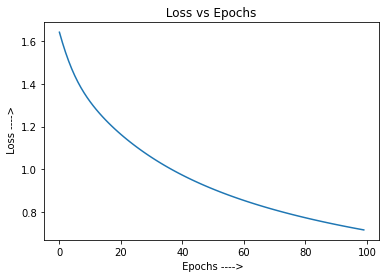

In [23]:
import matplotlib.pyplot as plt
print(model_predict[6])
plt.plot(model_predict[6])
plt.title(" Loss vs Epochs ")
plt.ylabel(" Loss ---->")
plt.xlabel(" Epochs ---->")
plt.show()